# Bayes Opt on 2D Regular Graph

In [215]:
import tensorflow as tf
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import networkx as nx
from gpflow.utilities import print_summary
import tensorflow_probability as tfp
import seaborn as sns

In [216]:
import sys
import os
project_root = os.path.abspath("../..")
sys.path.append(project_root)

In [217]:
from efficient_graph_gp.graph_kernels import diffusion_kernel, get_normalized_laplacian, generate_noisy_samples
from efficient_graph_gp.gpflow_kernels import GraphDiffusionKernel
from utils import plot_network_graph, plot_gp_fit, compute_fro

In [218]:
def gp_inference(X,Y,X_new, graph_kernel):
    model = gpflow.models.GPR(data=(X, Y), kernel=graph_kernel, mean_function=None)
    model.likelihood.variance.prior = tfp.distributions.LogNormal(loc=np.log(0.07), scale=0.5)
    gpflow.optimizers.Scipy().minimize(model.training_loss, model.trainable_variables)
    mean, variance = model.predict_f(X_new)
    stddev = tf.sqrt(variance)
    return model, mean, stddev

def plot_noisy_3d(Y_noisy, mesh_size, cmap='viridis'):
    """
    Plots a 3D surface of the noisy sampled data on a 2D grid.

    Parameters:
    - Y_noisy: 1D or 2D array-like of noisy sampled data.
    - mesh_size: The size of one dimension of the square mesh grid.
    - cmap: Colormap for the surface plot (default 'viridis').
    """
    # Prepare the grid for plotting
    x = np.arange(mesh_size)
    y = np.arange(mesh_size)
    X, Y = np.meshgrid(x, y)

    # Reshape Y_noisy to a 2D grid if needed
    Z = np.array(Y_noisy).reshape(mesh_size, mesh_size)

    # Create a 3D figure and axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    surf = ax.plot_surface(X, Y, Z, cmap=cmap)

    # Add a color bar which maps values to colors
    fig.colorbar(surf, shrink=0.5, aspect=5)

    # Set labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Noisy Data Value')
    plt.title('Noisy Sampled Data in 3D')

    plt.show()
    
def plot_gp_with_subsamples(Y_full, mesh_size, subsample_idx, Y_subsampled, 
                            title='GP Surface with Subsampled Data', cmap='viridis'):
    """
    Plots a 3D GP surface with overlaid subsampled data points.

    Parameters:
    -----------
    Y_full : array-like
        The full set of GP predictions or true values on a grid as a 1D array of length mesh_size**2.
    mesh_size : int
        The size of one dimension of the mesh grid (assuming a square grid).
    subsample_idx : array-like
        Indices of the subsampled points within the grid (flattened index).
    Y_subsampled : array-like
        Values corresponding to the subsampled data points.
    title : str, optional
        Title for the plot. Default is 'GP Surface with Subsampled Data'.
    cmap : str, optional
        Colormap for the surface. Default is 'viridis'.

    Returns:
    --------
    None
        Displays a 3D plot.
    """
    # Convert inputs to numpy arrays
    Y_full = np.array(Y_full)
    subsample_idx = np.array(subsample_idx)
    Y_subsampled = np.array(Y_subsampled)

    # Verify that Y_full length matches mesh_size^2
    if Y_full.size != mesh_size**2:
        raise ValueError("Length of Y_full does not match mesh_size squared.")

    # Create the grid for the full surface
    x = np.arange(mesh_size)
    y = np.arange(mesh_size)
    X_grid, Y_grid = np.meshgrid(x, y)
    
    # Reshape the full surface data
    Z_full = Y_full.reshape(mesh_size, mesh_size)

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the full GP surface
    surf = ax.plot_surface(X_grid, Y_grid, Z_full, cmap=cmap, edgecolor='none', alpha=0.8)
    fig.colorbar(surf, shrink=0.5, aspect=10, label='Value')

    # Compute the grid coordinates for subsampled points
    subsampled_y = subsample_idx // mesh_size
    subsampled_x = subsample_idx % mesh_size
    subsampled_z = Y_subsampled.flatten()

    # Overlay the subsampled data points as red scatter points
    ax.scatter(subsampled_x, subsampled_y, subsampled_z, color='r', s=50, label='Subsampled Data')

    # Set labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Value')
    ax.set_title(title)
    ax.legend()

    # Optionally adjust the viewing angle
    ax.view_init(elev=30, azim=225)  # Modify as needed

    plt.show()

def plot_error_field(Y_true, Y_pred, mesh_size, observation_positions=None, title='Error Field', cmap='coolwarm'):
    """
    Plots the error field between true and predicted values on a 2D grid.

    Parameters:
    -----------
    Y_true : array-like
        The true values on a grid as a 1D array of length mesh_size**2.
    Y_pred : array-like
        The predicted values on a grid as a 1D array of length mesh_size**2.
    mesh_size : int
        The size of one dimension of the mesh grid (assuming a square grid).
    observation_positions : array-like, optional
        Indices of the observed points within the grid (flattened index).
    title : str, optional
        Title for the plot. Default is 'Error Field'.
    cmap : str, optional
        Colormap for the error field. Default is 'coolwarm'.

    Returns:
    --------
    None
        Displays a 2D contour plot.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Convert inputs to numpy arrays
    Y_true = np.array(Y_true).reshape(-1)
    Y_pred = np.array(Y_pred).reshape(-1)

    # Verify that Y_true and Y_pred lengths match mesh_size^2
    if Y_true.size != mesh_size**2 or Y_pred.size != mesh_size**2:
        raise ValueError("Length of Y_true or Y_pred does not match mesh_size squared.")

    # Compute the error field
    error_field = np.abs(Y_true - Y_pred)

    # Create the grid for the error field
    x = np.linspace(0, mesh_size - 1, mesh_size)
    y = np.linspace(0, mesh_size - 1, mesh_size)
    X_grid, Y_grid = np.meshgrid(x, y)

    # Reshape the error field
    Z_error = error_field.reshape(mesh_size, mesh_size)

    # Create a 2D contour plot
    fig, ax = plt.subplots(figsize=(10, 7))

    # Plot the contour
    contour = ax.contourf(X_grid, Y_grid, Z_error, levels=25, cmap=cmap)
    cbar = fig.colorbar(contour, ax=ax, label='Error')

    # Overlay the observation positions as black scatter points
    if observation_positions is not None:
        obs_y = observation_positions // mesh_size
        obs_x = observation_positions % mesh_size
        ax.scatter(obs_x, obs_y, color='k', s=50, label='Observed Data', marker='x')

    # Add labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title(title)
    if observation_positions is not None:
        ax.legend()

    # Show the plot
    plt.show()


In [219]:
# Parameters
mesh_size = 10
num_nodes = mesh_size**2
graph_type = '2D_mesh' # 'line', 'random', '2D_mesh'

In [220]:
if graph_type == 'line':
    adjacency_matrix = np.eye(num_nodes, k=1) + np.eye(num_nodes, k=-1)  # Circular adjacency matrix
elif graph_type == 'random':
    probability = 0.1  # Probability of edge creation
    G = nx.erdos_renyi_graph(num_nodes, probability, directed=False)  # Ensure the graph is undirected
    adjacency_matrix = nx.to_numpy_array(G)  # Convert to adjacency matrix
elif graph_type == '2D_mesh':
    adjacency_matrix = nx.adjacency_matrix(nx.grid_2d_graph(mesh_size, mesh_size)).todense()
    

In [221]:
# G = nx.from_numpy_array(adjacency_matrix)
# nx.draw(G)

In [222]:
beta_sample = 5
noise_std = 0.1
kernel_std = 5

In [223]:
K_true = kernel_std * diffusion_kernel(adjacency_matrix, beta_sample)
Y = generate_noisy_samples(K_true, noise_std=0, seed=10)
Y_noisy = generate_noisy_samples(K_true,noise_std=noise_std, seed=10)
X = tf.convert_to_tensor(np.arange(num_nodes, dtype=np.float64).reshape(-1, 1))  # Input features (nodes)

In [224]:
def plot_2d_contour(Y, X, mesh_size, title='2D Contour of Y', cmap='viridis'):
    """
    Plots a 2D contour of the values in Y.

    Parameters:
    -----------
    Y : array-like
        The values to be plotted as a 1D array of length mesh_size**2.
    X : array-like
        The input features (nodes) as a 1D array of length mesh_size**2.
    mesh_size : int
        The size of one dimension of the mesh grid (assuming a square grid).
    title : str, optional
        Title for the plot. Default is '2D Contour of Y'.
    cmap : str, optional
        Colormap for the contour plot. Default is 'viridis'.

    Returns:
    --------
    None
        Displays a 2D contour plot.
    """
    # Convert inputs to numpy arrays
    Y = np.array(Y).reshape(-1)
    X = np.array(X).reshape(-1)

    # Verify that Y length matches mesh_size^2
    if Y.size != mesh_size**2:
        raise ValueError("Length of Y does not match mesh_size squared.")

    # Create the grid for the contour plot
    x = np.arange(mesh_size)
    y = np.arange(mesh_size)
    X_grid, Y_grid = np.meshgrid(x, y)

    # Reshape Y to a 2D grid
    Z = Y.reshape(mesh_size, mesh_size)

    # Create a 2D contour plot
    fig, ax = plt.subplots(figsize=(10, 7))

    # Plot the contour
    contour = ax.contourf(X_grid, Y_grid, Z, levels=25, cmap=cmap)
    cbar = fig.colorbar(contour, ax=ax, label='Value')

    # Add labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title(title)

    # Show the plot
    plt.show()

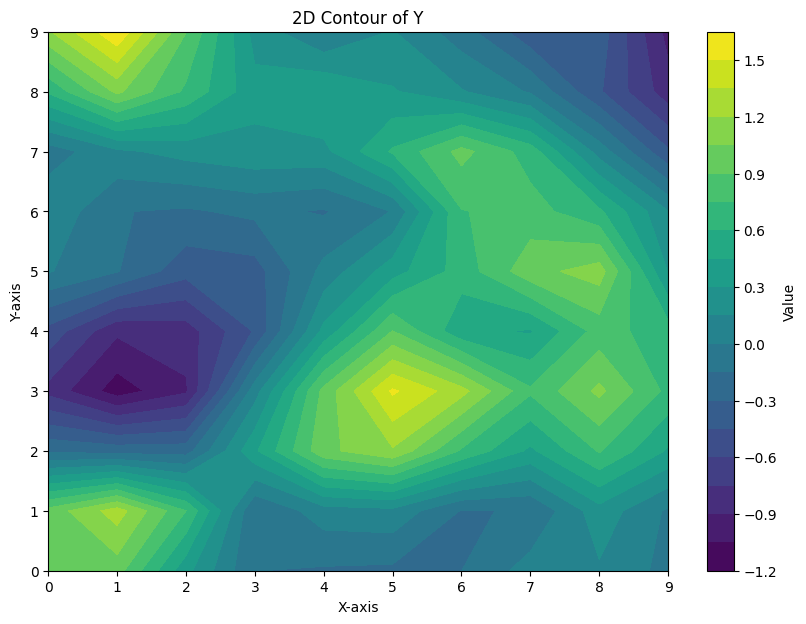

In [225]:
# Example usage
plot_2d_contour(Y_noisy, X, mesh_size, title='2D Contour of Y', cmap='viridis')

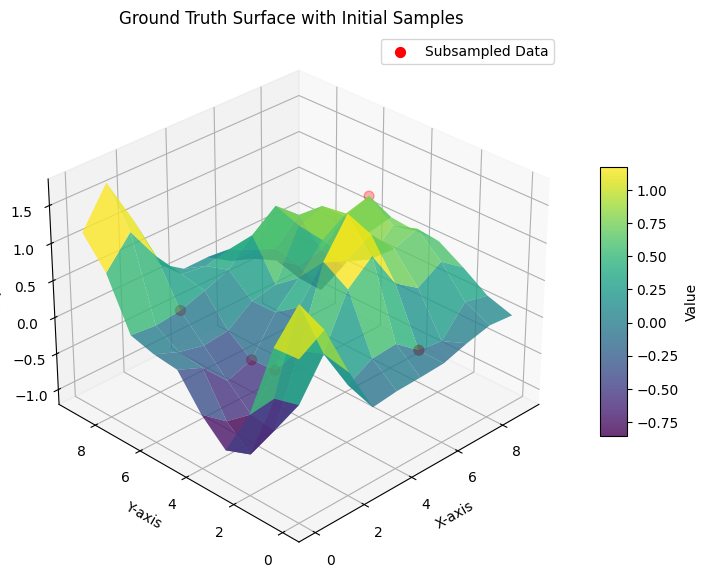

╒═════════════════════════╤═══════════╤══════════════════╤═══════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior     │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═══════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.beta         │ Parameter │ Softplus         │           │ True        │ ()      │ float64 │ 7.65858   │
├─────────────────────────┼───────────┼──────────────────┼───────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.sigma_f      │ Parameter │ Softplus         │           │ True        │ ()      │ float64 │ 2.12336   │
├─────────────────────────┼───────────┼──────────────────┼───────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │ LogNormal │ True        │ ()      │ float64 │ 0.0507923 │
╘═════════════════════════╧═══════════╧══════════════════╧══════

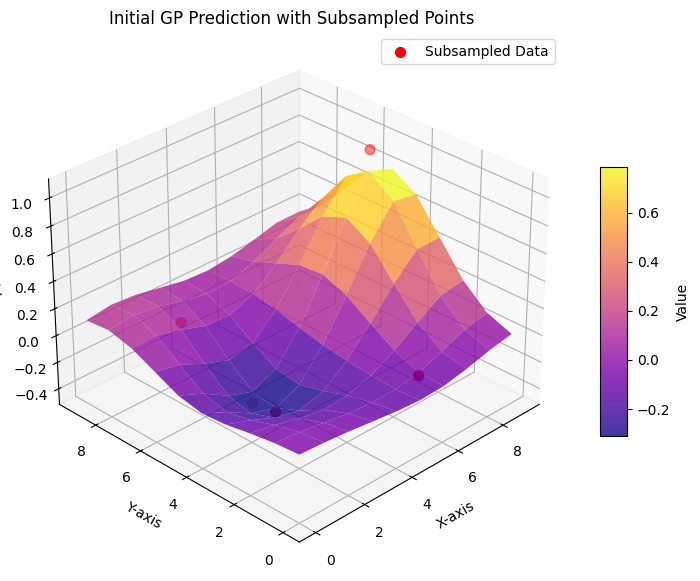

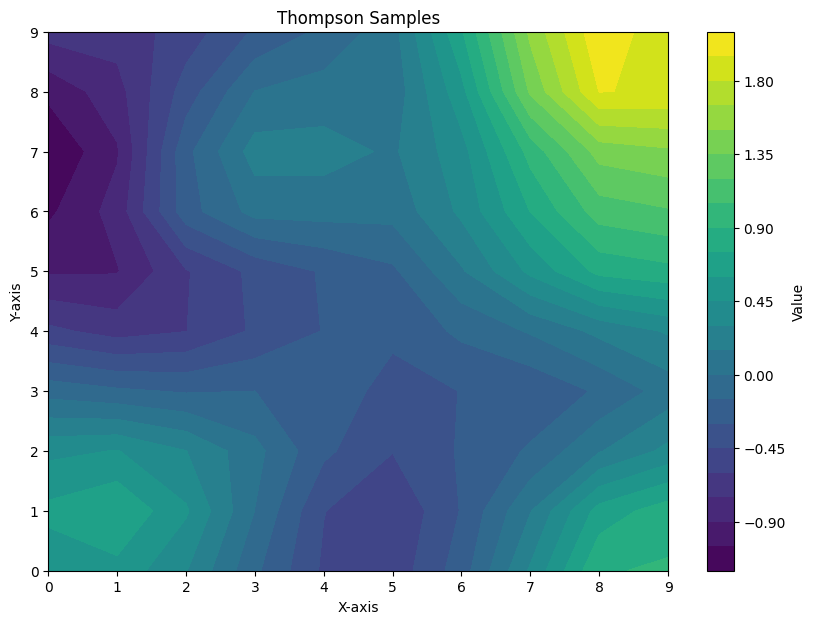

Iteration 1: Sample Index = 98, Sample Value = [-0.48486215]
╒═════════════════════════╤═══════════╤══════════════════╤═══════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior     │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═══════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.beta         │ Parameter │ Softplus         │           │ True        │ ()      │ float64 │ 5.17056   │
├─────────────────────────┼───────────┼──────────────────┼───────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.sigma_f      │ Parameter │ Softplus         │           │ True        │ ()      │ float64 │ 1.65052   │
├─────────────────────────┼───────────┼──────────────────┼───────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │ LogNormal │ True        │ ()      │ float64 │ 0.0518127 │
╘══

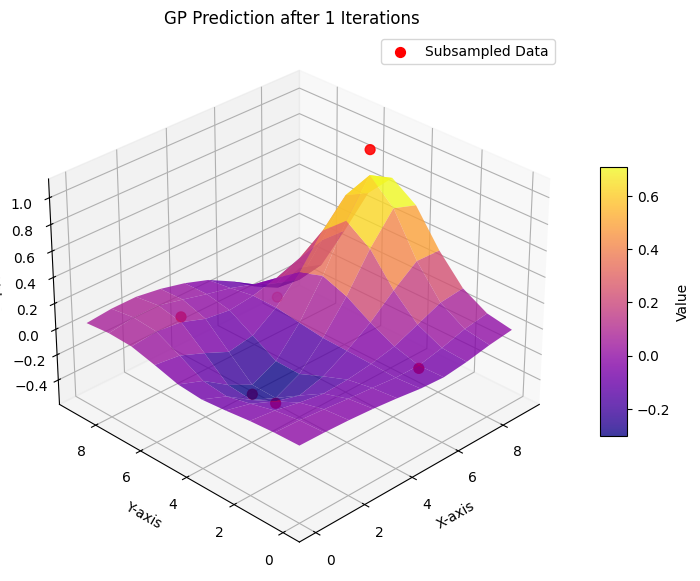

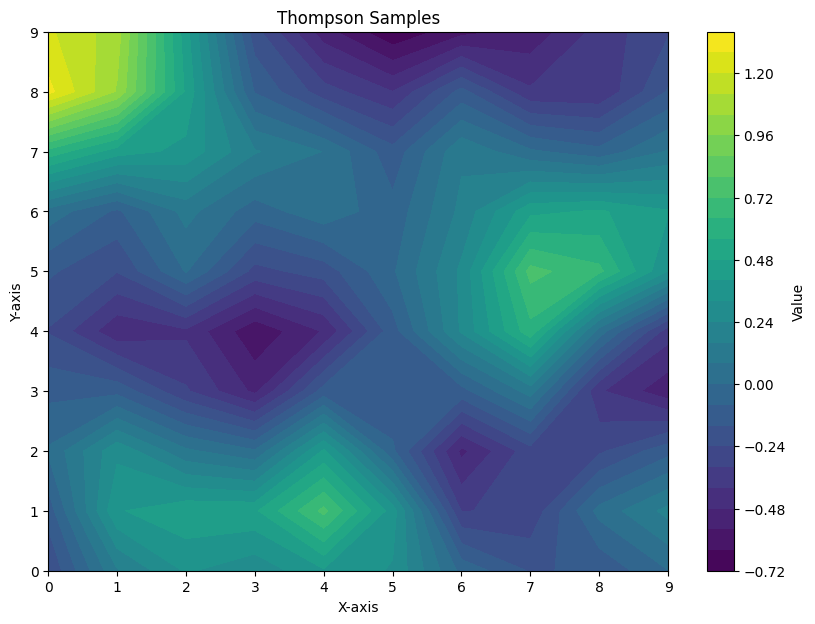

Iteration 2: Sample Index = 80, Sample Value = [0.76188416]
╒═════════════════════════╤═══════════╤══════════════════╤═══════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior     │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═══════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.beta         │ Parameter │ Softplus         │           │ True        │ ()      │ float64 │ 6.65897   │
├─────────────────────────┼───────────┼──────────────────┼───────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.sigma_f      │ Parameter │ Softplus         │           │ True        │ ()      │ float64 │ 2.01557   │
├─────────────────────────┼───────────┼──────────────────┼───────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │ LogNormal │ True        │ ()      │ float64 │ 0.0505092 │
╘═══

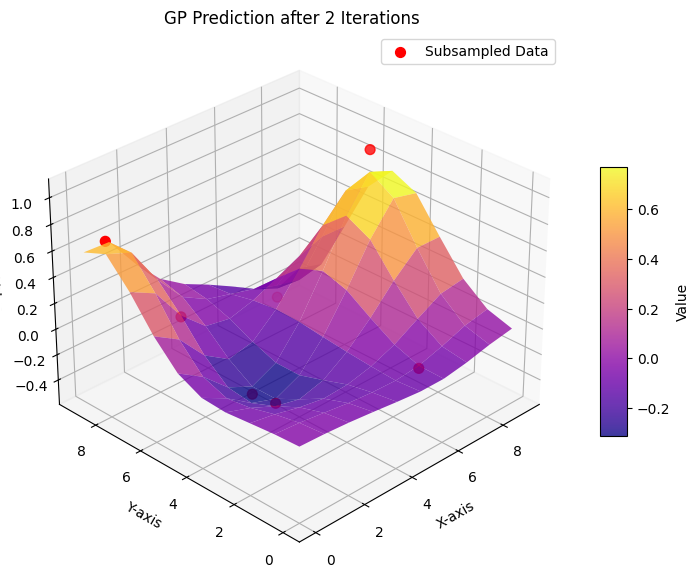

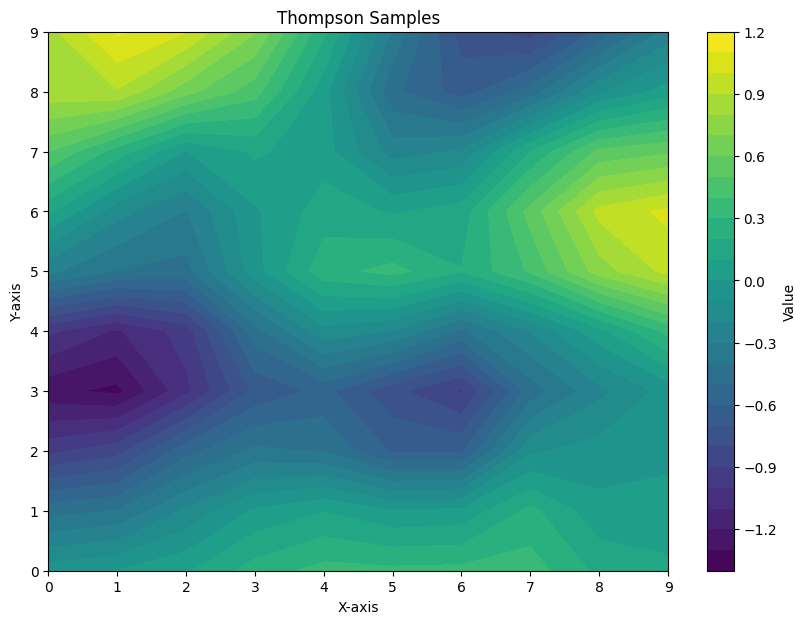

Iteration 3: Sample Index = 91, Sample Value = [1.65129124]
╒═════════════════════════╤═══════════╤══════════════════╤═══════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior     │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═══════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.beta         │ Parameter │ Softplus         │           │ True        │ ()      │ float64 │ 4.938     │
├─────────────────────────┼───────────┼──────────────────┼───────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.sigma_f      │ Parameter │ Softplus         │           │ True        │ ()      │ float64 │ 2.26139   │
├─────────────────────────┼───────────┼──────────────────┼───────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │ LogNormal │ True        │ ()      │ float64 │ 0.0533103 │
╘═══

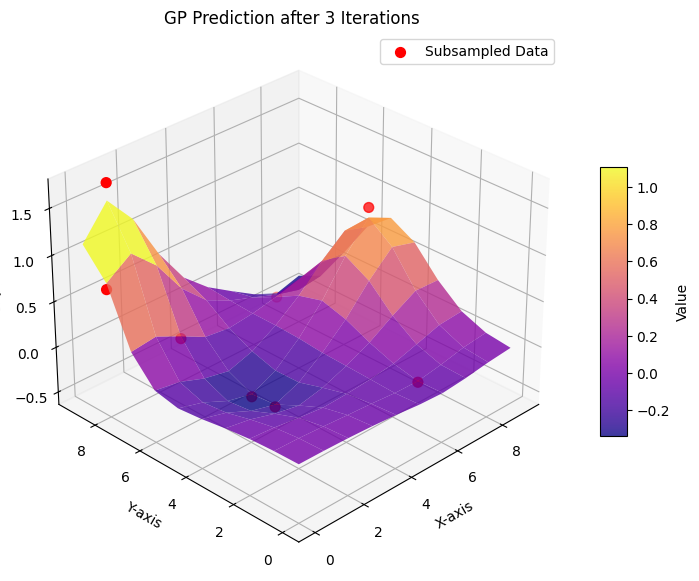

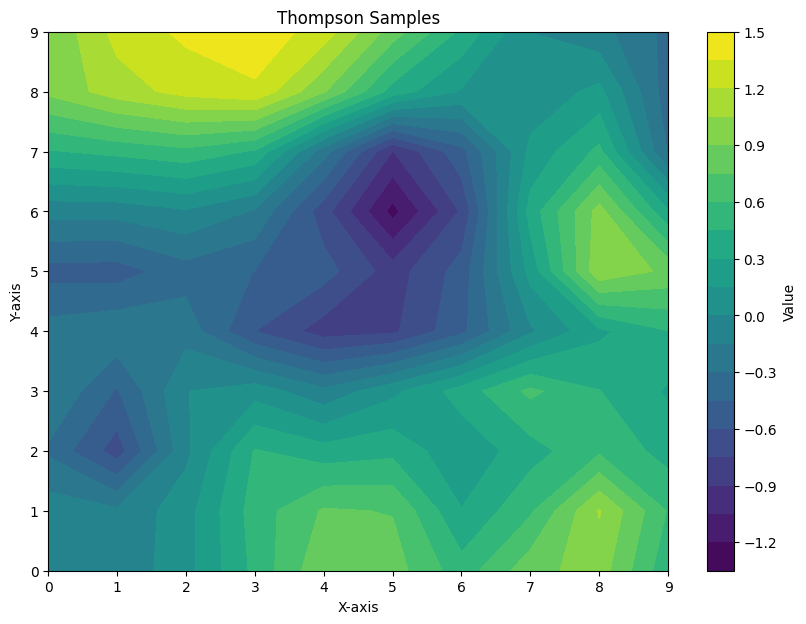

Iteration 4: Sample Index = 93, Sample Value = [0.25632575]
╒═════════════════════════╤═══════════╤══════════════════╤═══════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                    │ class     │ transform        │ prior     │ trainable   │ shape   │ dtype   │    value │
╞═════════════════════════╪═══════════╪══════════════════╪═══════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.kernel.beta         │ Parameter │ Softplus         │           │ True        │ ()      │ float64 │ 4.34556  │
├─────────────────────────┼───────────┼──────────────────┼───────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.sigma_f      │ Parameter │ Softplus         │           │ True        │ ()      │ float64 │ 1.97286  │
├─────────────────────────┼───────────┼──────────────────┼───────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │ LogNormal │ True        │ ()      │ float64 │ 0.053705 │
╘═══════════

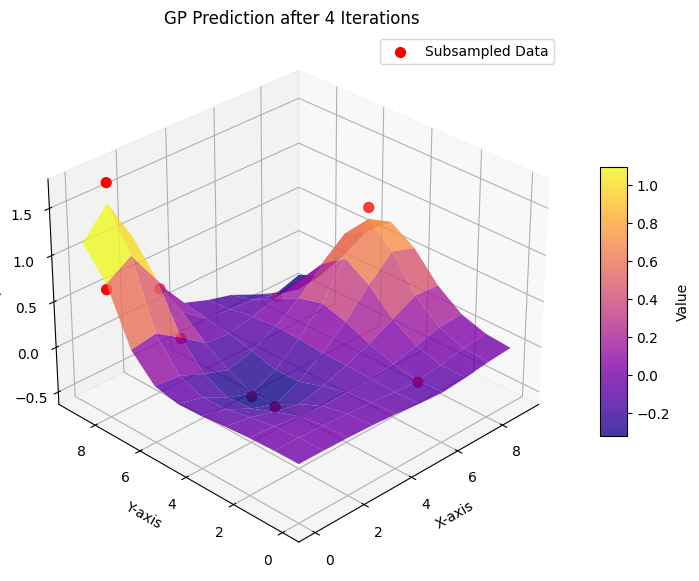

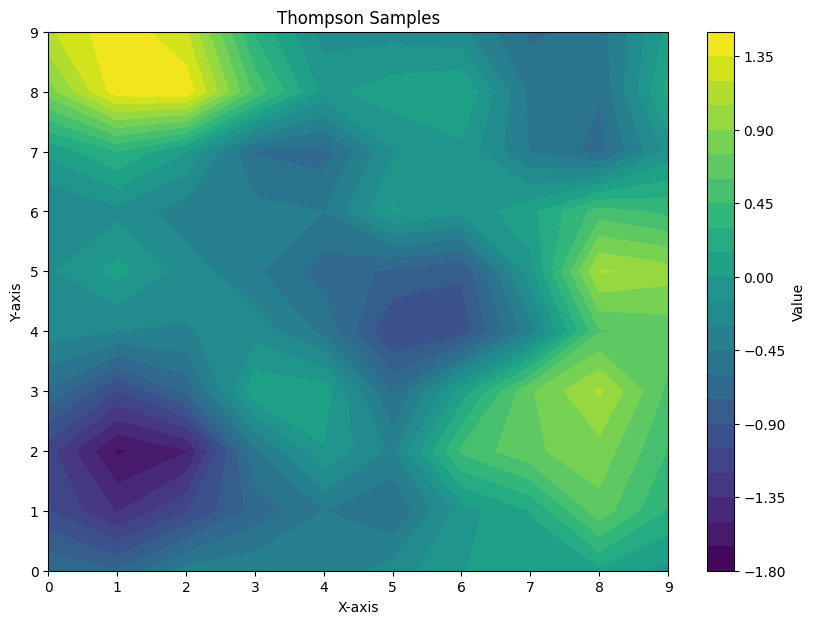

Iteration 5: Sample Index = 91, Sample Value = [1.65129124]
╒═════════════════════════╤═══════════╤══════════════════╤═══════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior     │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═══════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.beta         │ Parameter │ Softplus         │           │ True        │ ()      │ float64 │ 3.99771   │
├─────────────────────────┼───────────┼──────────────────┼───────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.sigma_f      │ Parameter │ Softplus         │           │ True        │ ()      │ float64 │ 1.96668   │
├─────────────────────────┼───────────┼──────────────────┼───────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │ LogNormal │ True        │ ()      │ float64 │ 0.0459723 │
╘═══

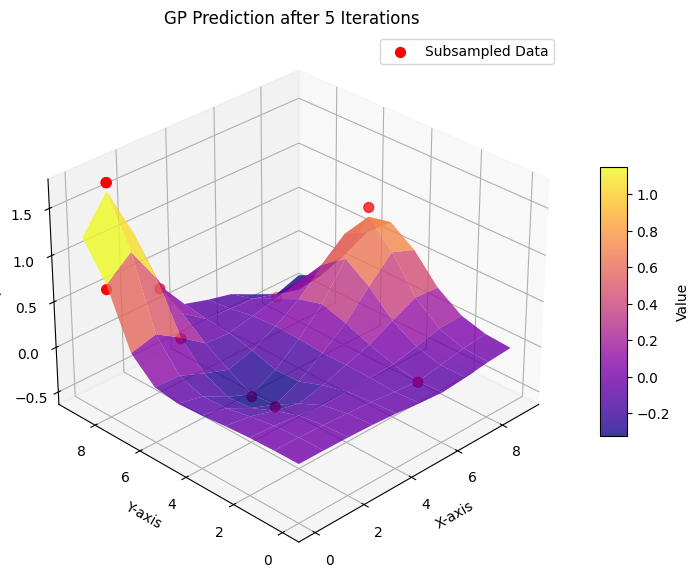

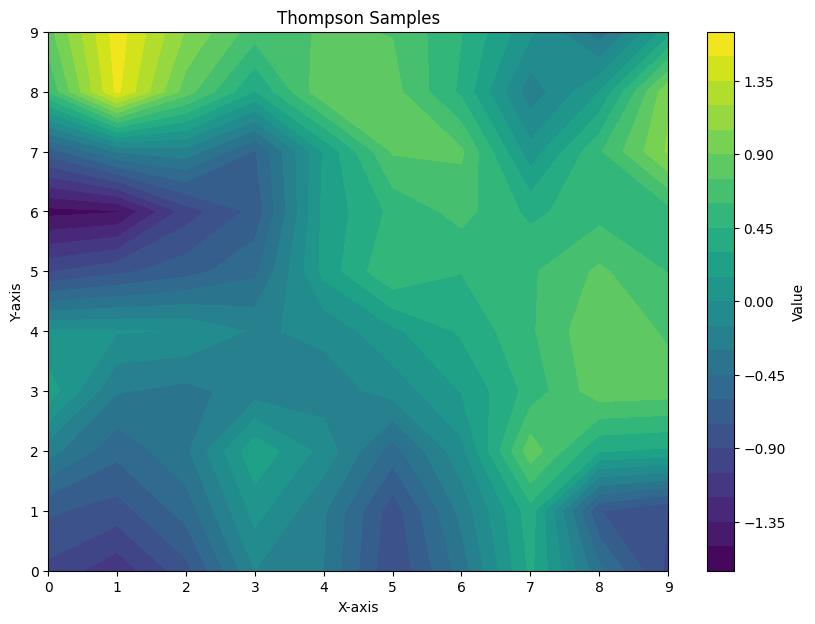

Iteration 6: Sample Index = 91, Sample Value = [1.65129124]
╒═════════════════════════╤═══════════╤══════════════════╤═══════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior     │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═══════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.beta         │ Parameter │ Softplus         │           │ True        │ ()      │ float64 │ 3.90781   │
├─────────────────────────┼───────────┼──────────────────┼───────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.sigma_f      │ Parameter │ Softplus         │           │ True        │ ()      │ float64 │ 1.96539   │
├─────────────────────────┼───────────┼──────────────────┼───────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │ LogNormal │ True        │ ()      │ float64 │ 0.0403953 │
╘═══

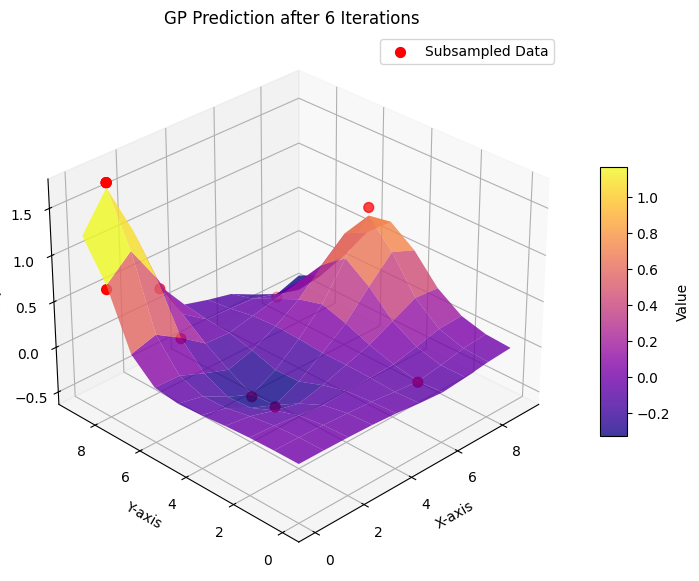

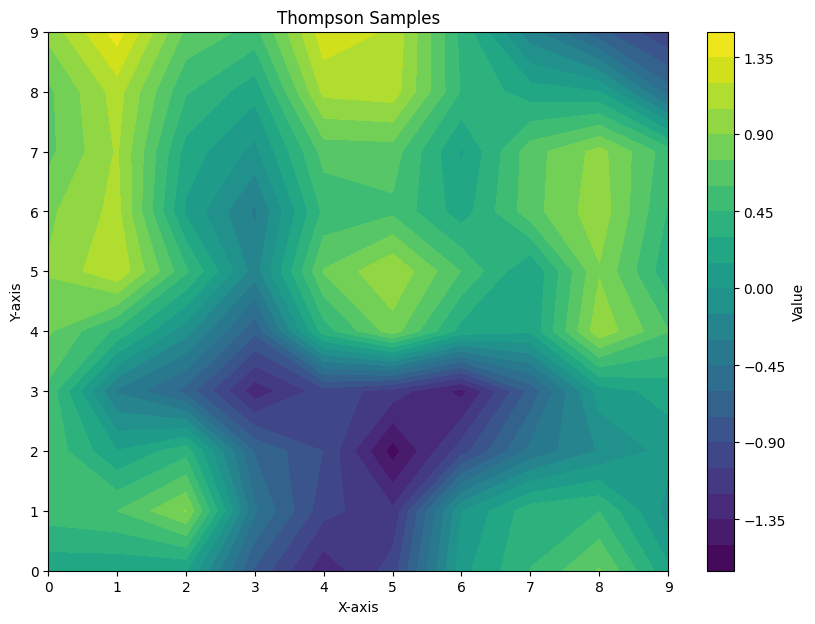

Iteration 7: Sample Index = 91, Sample Value = [1.65129124]
╒═════════════════════════╤═══════════╤══════════════════╤═══════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior     │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═══════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.beta         │ Parameter │ Softplus         │           │ True        │ ()      │ float64 │ 3.86674   │
├─────────────────────────┼───────────┼──────────────────┼───────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.sigma_f      │ Parameter │ Softplus         │           │ True        │ ()      │ float64 │ 1.96385   │
├─────────────────────────┼───────────┼──────────────────┼───────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │ LogNormal │ True        │ ()      │ float64 │ 0.0356886 │
╘═══

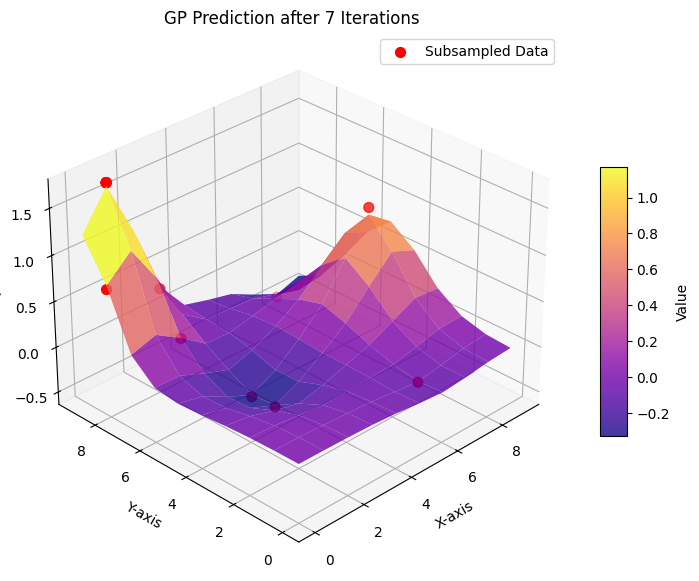

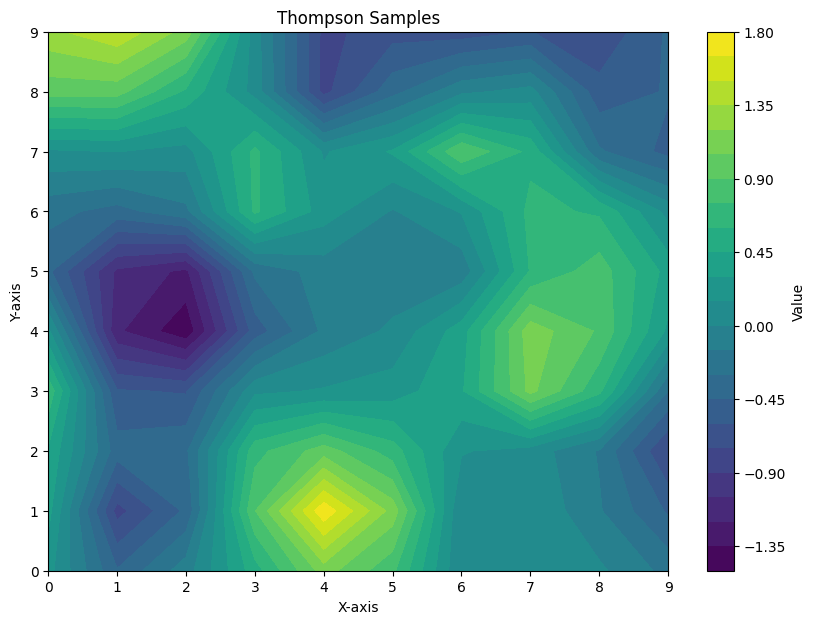

Iteration 8: Sample Index = 14, Sample Value = [0.11007248]
╒═════════════════════════╤═══════════╤══════════════════╤═══════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior     │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═══════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.beta         │ Parameter │ Softplus         │           │ True        │ ()      │ float64 │ 3.82015   │
├─────────────────────────┼───────────┼──────────────────┼───────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.sigma_f      │ Parameter │ Softplus         │           │ True        │ ()      │ float64 │ 1.85298   │
├─────────────────────────┼───────────┼──────────────────┼───────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │ LogNormal │ True        │ ()      │ float64 │ 0.0353567 │
╘═══

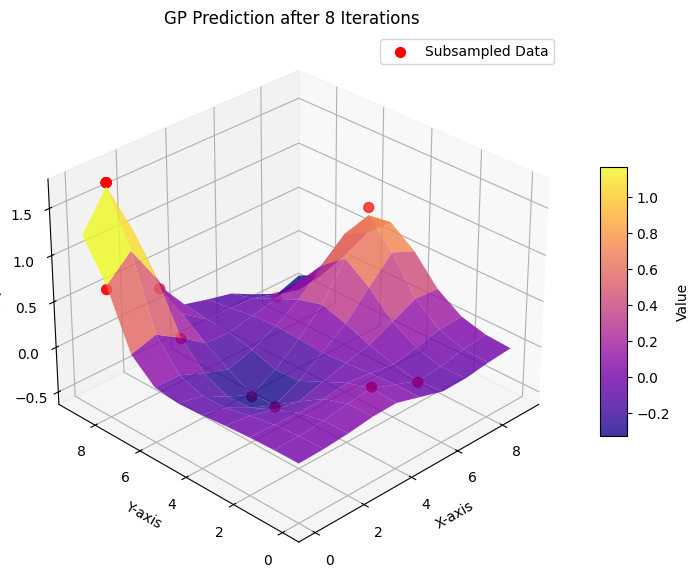

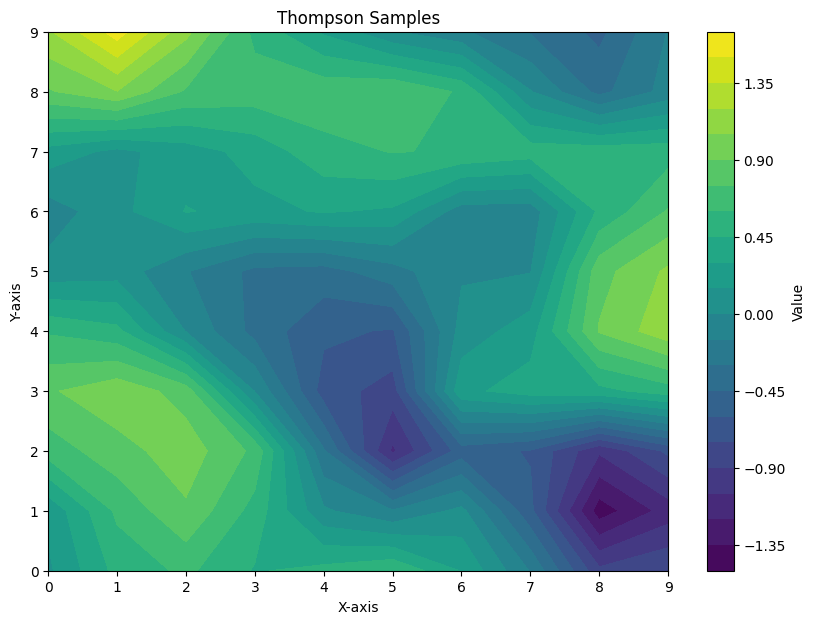

Iteration 9: Sample Index = 91, Sample Value = [1.65129124]
╒═════════════════════════╤═══════════╤══════════════════╤═══════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                    │ class     │ transform        │ prior     │ trainable   │ shape   │ dtype   │    value │
╞═════════════════════════╪═══════════╪══════════════════╪═══════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.kernel.beta         │ Parameter │ Softplus         │           │ True        │ ()      │ float64 │ 3.79503  │
├─────────────────────────┼───────────┼──────────────────┼───────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.sigma_f      │ Parameter │ Softplus         │           │ True        │ ()      │ float64 │ 1.8513   │
├─────────────────────────┼───────────┼──────────────────┼───────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │ LogNormal │ True        │ ()      │ float64 │ 0.031307 │
╘═══════════

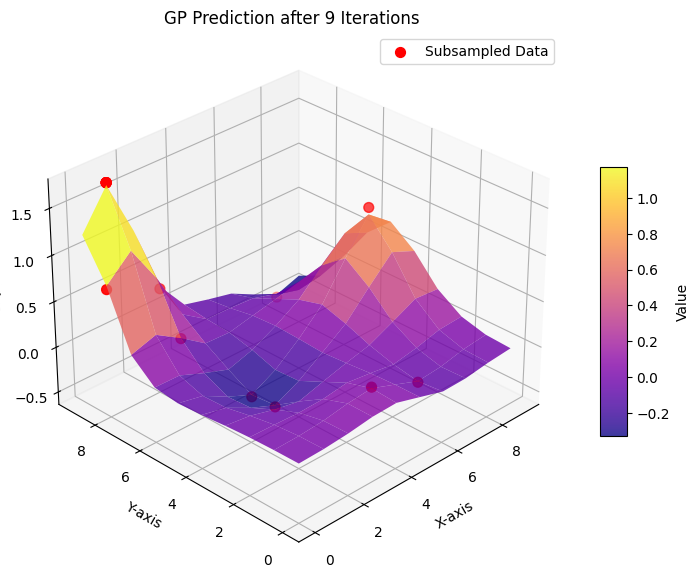

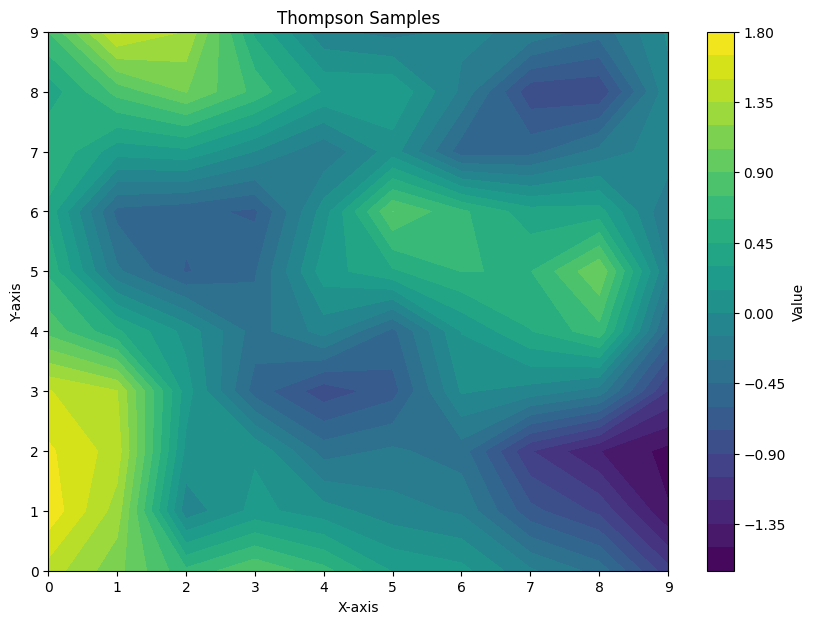

Iteration 10: Sample Index = 10, Sample Value = [0.92578039]
╒═════════════════════════╤═══════════╤══════════════════╤═══════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior     │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═══════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.beta         │ Parameter │ Softplus         │           │ True        │ ()      │ float64 │ 3.905     │
├─────────────────────────┼───────────┼──────────────────┼───────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.sigma_f      │ Parameter │ Softplus         │           │ True        │ ()      │ float64 │ 1.9362    │
├─────────────────────────┼───────────┼──────────────────┼───────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │ LogNormal │ True        │ ()      │ float64 │ 0.0314142 │
╘══

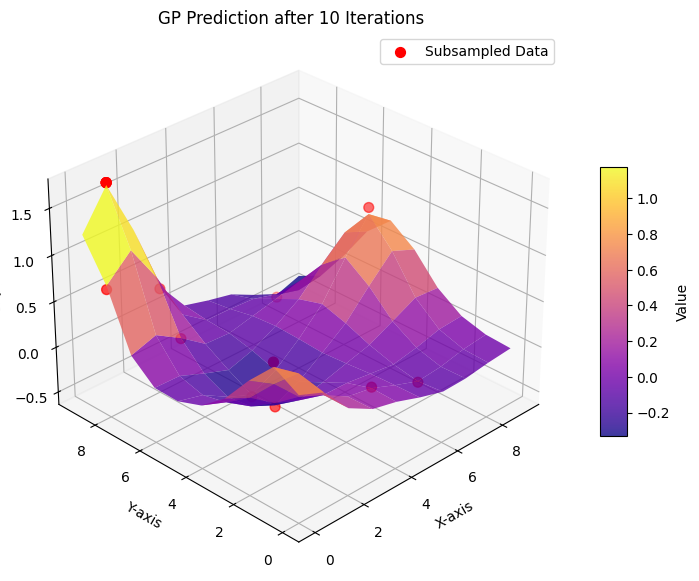

Best value found: [1.65129124] at index 91
Ground truth value: [1.65129124] at index 91


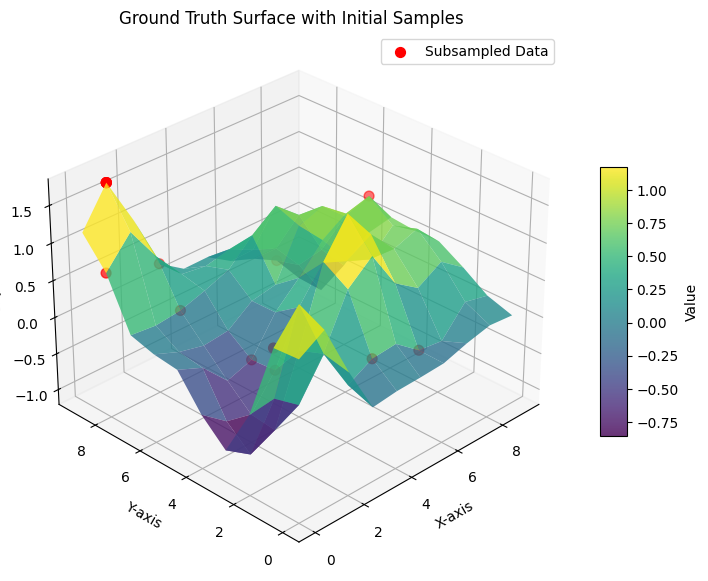

In [226]:
# Bayes Opt

# 1. start with 10% samples
subsample_factor = 20
subsample_idx = np.random.choice(num_nodes, num_nodes//subsample_factor, replace=False)
X_subsampled = X.numpy()[subsample_idx]
Y_subsampled = Y[subsample_idx]
# plot the initial samples
plot_gp_with_subsamples(Y, mesh_size, subsample_idx, Y_subsampled, title='Ground Truth Surface with Initial Samples', cmap='viridis')


# 2. fit the GP model with the initial samples
bayesopt_kernel = GraphDiffusionKernel(adjacency_matrix=adjacency_matrix)
model, mean, stddev = gp_inference(X_subsampled, Y_subsampled, X, bayesopt_kernel)
print_summary(model)
plot_gp_with_subsamples(mean.numpy(), mesh_size, subsample_idx, Y_subsampled,
                        title='Initial GP Prediction with Subsampled Points', cmap='plasma')


# 3. Do Bayes Optimization with Thompson Sampling
num_iter = 10
best_value_found = -np.inf
best_point = None
for i in range(num_iter):
    # 3.1. Thompson Sampling
    thompson_samples = model.predict_f_samples(X, 1).numpy().reshape(-1)
    # Plot the Thompson samples
    plot_2d_contour(thompson_samples, X, mesh_size, title='Thompson Samples', cmap='viridis')
    next_sample_idx = np.argmax(thompson_samples)
    next_sample_value = Y[next_sample_idx]
    print(f'Iteration {i+1}: Sample Index = {next_sample_idx}, Sample Value = {next_sample_value}')
    if next_sample_value > best_value_found:
        best_value_found = next_sample_value
        best_point = next_sample_idx

    subsample_idx = np.append(subsample_idx, next_sample_idx)
    X_subsampled = X.numpy()[subsample_idx]
    Y_subsampled = Y[subsample_idx]
    # 3.5. Fit the GP model with the updated samples
    model, mean, stddev = gp_inference(X_subsampled, Y_subsampled, X, bayesopt_kernel)
    print_summary(model)
    plot_gp_with_subsamples(mean.numpy(), mesh_size, subsample_idx, Y_subsampled,
                            title=f'GP Prediction after {i+1} Iterations', cmap='plasma')
    plt.show()

print(f'Best value found: {best_value_found} at index {best_point}')

gt_best_point = np.argmax(Y)
gt_best_value = Y[gt_best_point]
print(f'Ground truth value: {gt_best_value} at index {gt_best_point}')
plot_gp_with_subsamples(Y, mesh_size, subsample_idx, Y_subsampled, title='Ground Truth Surface with Initial Samples', cmap='viridis')
